In [33]:
import pandas as pd
import numpy as np
import csv
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import logging
import math
from matplotlib.animation import FuncAnimation
from lmfit import minimize, fit_report, Parameters
from aim2_population_model_spatial_aff_parallel import get_mod_spike
from model_constants import (MC_GROUPS, LifConstants)
from popul_model import pop_model
from aim2_population_model_spatial_aff_parallel import Afferent, SimulationConfig, Simulation

### Model Parameters

In [34]:
# lmpars_init_dict = {}
# lmpars = Parameters()
# lmpars.add('tau1', value=8, vary=False) #tauRI()
# lmpars.add('tau2', value=200, vary=False) #tauSI
# lmpars.add('tau3', value=1744.6, vary=False)#tau USI
# lmpars.add('tau4', value=np.inf, vary=False)
# lmpars.add('k1', value=.74, vary=False, min=0) #a constant
# lmpars.add('k2', value=2.75, vary=False, min=0) #b constant
# lmpars.add('k3', value=.07, vary=False, min=0) #c constant
# lmpars.add('k4', value=.0312, vary=False, min=0)
# lmpars_init_dict['t3f12v3final'] = lmpars

# Global Variables
lmpars_init_dict = {}
lmpars = Parameters()
lmpars.add('tau1', value=8, vary=False) #tauRI(ms)
lmpars.add('tau2', value=200, vary=False) #tauSI(ms)
lmpars.add('tau3', value=1744.6, vary=False)#tauUSI(ms)
lmpars.add('tau4', value=np.inf, vary=False)
lmpars.add('k1', value=.74, vary=False, min=0) #a constant
lmpars.add('k2', value=2.75, vary=False, min=0) #b constant
lmpars.add('k3', value=.07, vary=False, min=0) #c constant
lmpars.add('k4', value=.0312, vary=False, min=0)
lmpars_init_dict['t3f12v3final'] = lmpars

### Population Model Class with methods for Raidal & Spatial Model and Plotting funtino for radial

In [50]:
class VF_Population_Model:
    
    def __init__(self, vf_tip_size, aff_type, scaling_factor ):
        self.sf = scaling_factor
        self.vf_tip_size = vf_tip_size
        self.aff_type = aff_type
        self.results = None
        self.stress_data = None
        self.x_coords = None
        self.y_coords = None
        self.time_of_firing = None
        self.radial_stress_data = None
        self.radial_iff_data = None
        self.SA_radius = None
        self.g = None
        self.h = None
    """
        functino takes in a vf_tip_size (given that that there is data assicated with it) an
        afferent type, and runs the single unit model for all of those coordinates with the data

        firing time: takes either pike or a certain time, during thd ramp phase when the 
        
    """
    def spatial_stress_vf_model(self, time_of_firing = "peak", g=0.4, h= 1):
        self.time_of_firing = time_of_firing
        self.g = g
        self.h = h
        #reading data in 
        # coords = pd.read_csv(f"data/vfspatial/{self.vf_tip_size}_spatial_coords.csv", header = None)

        #reading in Anikas new coords 

        coords = pd.read_csv(f"data/anika_new_data/{self.vf_tip_size}/{self.vf_tip_size}_spatial_coords_corr.csv")

        #assinging the instance variables for all the x coords and y coords of spatial points
        self.x_coords = [float(row[0]) for row in coords.iloc[0:].values]
        self.y_coords = [float(row[1]) for row in coords.iloc[0:].values]
        # stress_data = pd.read_csv(f"data/vfspatial/{self.vf_tip_size}_spatial_stress.csv" )
        


        stress_data = pd.read_csv(f"data/anika_new_data/{self.vf_tip_size}/{self.vf_tip_size}_spatial_stress_corr.csv")
        time = stress_data['Time (ms)'].to_numpy()

        afferent_type = []
        x_pos = []
        y_pos = []
        spikes = []
        mean_firing_frequency = []
        peak_firing_frequency = []
        first_spike_time = []
        last_spike_time = []
        stress_trace = []
        entire_iff = []

        #iterating through each of the coordinates
        for i, row in coords.iloc[0:].iterrows():
            i+=1 #incrementing so index starts from first index
            # print(f"index: {i}, row: {row}")
            #getting stress data
            
            if f"Coord {i} Stress (kPa)" in stress_data.columns:
                stress = stress_data[f"Coord {i} Stress (kPa)"] * self.sf

                #Debugging Statement
                # print(f"RECIEVING STRESS DATA AT COORD {i} at x:{row.iloc[0]}and y:{row.iloc[1]} MEAN STRESS IS {np.mean(stress)}")
            else:
                logging.warning("STRESS VALUE COULD NOT BE INDEXED")

            lmpars = lmpars_init_dict['t3f12v3final']
            if self.aff_type == "RA":
                lmpars['tau1'].value = 2.5
                lmpars['tau2'].value = 200
                lmpars['tau3'].value = 1
                lmpars['k1'].value = 35
                lmpars['k2'].value = 0
                lmpars['k3'].value = 0.0
                lmpars['k4'].value = 0

            groups = MC_GROUPS
            mod_spike_time, mod_fr_inst = get_mod_spike(lmpars, groups, time, stress, g=self.g,h =self.h )

            if len(mod_spike_time) == 0 or len(mod_fr_inst) == 0:
                logging.warning(f"SPIKES COULD NOT BE GENERATED FOR COORD {i} and X: {row.iloc[0]} and Y:{row.iloc[1]}, BECAUSE STRESS WAS TOO LOW")
                continue

            if len(mod_spike_time) != len(mod_fr_inst):
                if len(mod_fr_inst) > 1:
                    mod_fr_inst_interp = np.interp(mod_spike_time, time, mod_fr_inst)
                else:
                    mod_fr_inst_interp = np.zeros_like(mod_spike_time)
            else:
                mod_fr_inst_interp = mod_fr_inst

            features, _ = pop_model(mod_spike_time,mod_fr_inst_interp)
    
            #appending stuff to lists
            afferent_type.append(self.aff_type)
            x_pos.append(row.iloc[0])
            y_pos.append(row.iloc[1])
            spikes.append(len(mod_spike_time) if len(mod_spike_time) !=0 else None)
            mean_firing_frequency.append(features["Average Firing Rate"])
            if time_of_firing == "peak":
                peak_firing_frequency.append(np.max(mod_fr_inst_interp))
            else:
                #firing frequency at a specific time , finds the closest iff value to the specified time 
                # Find the index of the mod_spike_time closest to time_of_firing
                closest_spike_idx = np.argmin(np.abs(np.array(mod_spike_time) - time_of_firing))
                # Get the corresponding mod_fr_inst_interp value tied to this spike time
                temp_fr_inst_interp = mod_fr_inst_interp[closest_spike_idx]
                # Append the instantaneous firing frequency at the closest spike time
                peak_firing_frequency.append(temp_fr_inst_interp)
        
            first_spike_time.append(mod_spike_time[0] if len(mod_spike_time) != None else None)
            last_spike_time.append(mod_spike_time[-1])
            stress_trace.append(stress)
            entire_iff.append(mod_fr_inst_interp)
            
        model_results = {
            'afferent_type': self.aff_type,
            'x_position': x_pos,
            'y_position': y_pos,
            'num_of_spikes' : spikes,
            'mean_firing_frequency' : mean_firing_frequency,
            'peak_firing_frequency' : peak_firing_frequency, 
            'first_spike_time': first_spike_time,
            'last_spike_time' : last_spike_time,
            'each_coord_stress': stress_trace, 
            'entire_iff': entire_iff
        }

        self.results = model_results
        return model_results


    def radial_stress_vf_model(self,g= 0.4, h= 1):

        """ Read in the Radial which has sample stress traces for every 2mm from a center point
        to calculate firing"""
        self.g = g
        self.h = h

        #regex pattern for exstracting the distance from the middle point
        distance_regex = r'\d\.\d{2}'

        #Reading in the radial stress file
        # radial_stress = pd.read_csv(f"data/vfspatial/{vf_tip_size}_radial_stress.csv")
        #Reading the new anika data in
        radial_stress = pd.read_csv(f"data/anika_new_data/{self.vf_tip_size}/{self.vf_tip_size}_radial_stress_corr.csv")
        radial_time = radial_stress['Time (ms)'].to_numpy()
        
        stress_data = {}
        iff_data = {}
        not_generated_radii = []

        # Inner loop to iterate through radial distances
        for col in radial_stress.columns[1:]:
            LifConstants.set_resolution(1)
            distance_from_center = float(re.findall(distance_regex, col)[0])

            # Initialize lists for each coordinate-distance pair
            afferent_type = []
            spikes = []
            mean_firing_frequency = []
            peak_firing_frequency = []
            first_spike_time = []
            last_spike_time = []

            # if radial_spatial_flag:
            #     radial_stress_vals = radial_stress[col]
            #     radial_stress_max = np.max(radial_stress_vals)
            #     distance_scaling_factor = spatial_stress_max / radial_stress_max
            #     radial_spatial_flag = False
            
            #where the scaling happens
            scaled_stress = radial_stress[col] *  self.sf

            stress_data[distance_from_center] = {
                "Time": radial_time,
                distance_from_center: scaled_stress.to_numpy()
            }

            lmpars = lmpars_init_dict['t3f12v3final']
            if afferent_type == "RA":
                lmpars['tau1'].value = 2.5
                lmpars['tau2'].value = 200
                lmpars['tau3'].value = 1
                lmpars['k1'].value = 35
                lmpars['k2'].value = 0
                lmpars['k3'].value = 0.0
                lmpars['k4'].value = 0

            groups = MC_GROUPS
            mod_spike_time, mod_fr_inst = get_mod_spike(lmpars, groups, stress_data[distance_from_center]["Time"], stress_data[distance_from_center][distance_from_center],g=self.g, h = self.h)

            if len(mod_spike_time) == 0 or len(mod_fr_inst) == 0:
                logging.warning(f"SPIKES COULD NOT BE GENERATED FOR {self.vf_tip_size}")
                not_generated_radii.append(distance_from_center)
                iff_data[distance_from_center] = None
                continue

            if len(mod_spike_time) != len(mod_fr_inst):
                if len(mod_fr_inst) > 1:
                    mod_fr_inst_interp = np.interp(mod_spike_time, radial_time, mod_fr_inst)
                else:
                    mod_fr_inst_interp = np.zeros_like(mod_spike_time)
            else:
                mod_fr_inst_interp = mod_fr_inst

            features, _ = pop_model(mod_spike_time, mod_fr_inst_interp)

            # Append single values to the lists
            afferent_type.append(afferent_type)
            spikes.append(len(mod_spike_time) if len(mod_spike_time) != 0 else None)
            mean_firing_frequency.append(features["Average Firing Rate"])
            peak_firing_frequency.append(np.max(mod_fr_inst_interp))
            first_spike_time.append(mod_spike_time[0] if len(mod_spike_time) != 0 else None)
            last_spike_time.append(mod_spike_time[-1])

            # Store each coordinate-distance dictionary within iff_data
            iff_data[distance_from_center] = {
                'afferent_type': afferent_type,
                'num_of_spikes': spikes[0],
                'mean_firing_frequency': mean_firing_frequency[0],
                'peak_firing_frequency': peak_firing_frequency[0],
                'first_spike_time': first_spike_time[0],
                'last_spike_time': last_spike_time[0]
            }
        self.radial_stress_data = stress_data
        self.radial_iff_data = iff_data

    def plot_spatial_coords(self):
        """
        Plots the iffs on a grid for the original n points, the magniude of the peak firing
        frequency directly affects the size of the circle plotted, and the opacity
        """
        #colors for differnet afferents
        colors = {'SA': '#31a354', 'RA': '#3182bd'}
        plt.figure(figsize=(12, 8))

        # Plot the stimulus locations as circles
        x_positions = self.results.get("x_position")
        y_positions = self.results.get("y_position")
        mean_iffs = self.results.get("mean_firing_frequency")
        peak_iffs = self.results.get("peak_firing_frequency")


        for x,y, peak in zip(x_positions, y_positions, peak_iffs):
            print(f"x: {x} y: {y} peak_iff: {peak}")
            
        
        x_positions = [float(value) for value in x_positions]
        y_positions = [float(value) for value in y_positions]
        #scaling peak_iffs so it looks better when plotting
    
        alphas = [float(value)/max(peak_iffs) for value in peak_iffs]
  
        #Scatter plot
                # Plot the stimulus locations as circles
        for x_pos, y_pos, radius, alpha in zip(x_positions, y_positions, peak_iffs, alphas):
            plt.gca().add_patch(
                patches.Circle((x_pos, y_pos), radius*2, edgecolor='black', facecolor = colors.get(self.aff_type) , linewidth=1, alpha = 0.5)
            )
        
        #calculating the Stimulus Point
        idx_of_max_iff = mean_iffs.index(np.max(mean_iffs))
        x_stim = x_positions[idx_of_max_iff]
        y_stim = y_positions[idx_of_max_iff]

        plt.gca().add_patch(
            patches.Circle((x_stim,y_stim),self.SA_Radius, edgecolor='black', facecolor='none', linewidth=1) 
        )

        
        plt.xlabel('Length (mm)')
        plt.ylabel('Width (mm)')
        plt.title(f"{self.vf_tip_size} VF {self.aff_type} firing at {self.time_of_firing} ms Stress Distribution")
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.xlim(0,15)
        plt.ylim(0,15)
        # plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
        # plt.ylim(min(y_positions) - 1, max(y_positions) + 1)

        # plt.savefig(f"vf_graphs/aggregated_results_on_grid/{self.vf_tip_size}_{self.aff_type}_{self.time_of_firing}_constant_opacity.png")
        plt.savefig(f"vf_graphs/spatial_plots/{self.vf_tip_size}_{self.aff_type}_{self.time_of_firing}_constant_opacity.png")


    def run_single_unit_model_combined_graph(self, stress_threshold = 0):
        
        #variable for The radius for SA, setting it to a really large variable
        SA_radius = 0
        fig, axes = plt.subplots(5, 5, figsize=(20, 20))
        fig.subplots_adjust(hspace=0.5, wspace=0.4)

        axes = axes.flatten()

        # finding comon limits
        common_x_min = 0
        common_x_max = max(data['Time'][-1] for data in self.radial_stress_data.values())
        common_stress_max =0 
        xommon_iff_max = 0 

        legend = False
        # Iterate through each entry in the stress_data dictionary and each subplot
        for idx, (distance, data) in enumerate(self.radial_stress_data.items()):
            if idx >= 25:  # Only plot up to 25 entries for the 5x5 grid
                break
            
            time = data['Time']  # Extract the time array
            stress_values =  data[distance]  # Apply scaling factor


            lmpars = lmpars_init_dict['t3f12v3final']
            LifConstants.set_resolution(1)
            if self.aff_type == "RA":
                lmpars['tau1'].value = 2.5
                lmpars['tau2'].value = 200
                lmpars['tau3'].value = 1
                lmpars['k1'].value = 35
                lmpars['k2'].value = 0
                lmpars['k3'].value = 0.0
                lmpars['k4'].value = 0

            groups = MC_GROUPS

            ####added streses threshold logic 
            if np.max(stress_values) < stress_threshold:
                # Zero out the stress trace
                stress_values = np.zeros_like(stress_values)    


            ####
            mod_spike_time, mod_fr_inst = get_mod_spike(lmpars, groups, time, stress_values,g= self.g,h= self.h )


            if len(mod_spike_time) == 0 or len(mod_fr_inst) == 0:
                logging.warning(f"SPIKES COULD NOT BE GENERATED for distance {distance}")
                
                continue
            #updating the size rf of the stimlus 
            if distance > SA_radius:
                    SA_radius = distance
            if len(mod_spike_time) != len(mod_fr_inst):
                if len(mod_fr_inst) > 1:
                    mod_fr_inst_interp = np.interp(mod_spike_time, time, mod_fr_inst)
                else:
                    mod_fr_inst_interp = np.zeros_like(mod_spike_time)
            else:
                mod_fr_inst_interp = mod_fr_inst

            #addding the logic for the limits of stress and iff
            if not legend:
                common_stress_max = np.max(stress_values)+50
                common_iff_max = np.max(mod_fr_inst_interp*1e3)+50

            ax = axes[idx]
            ax2 = ax.twinx()  # Create twin axis on the right

            # Plot IFF (Hz) on the left y-axis
            ax.plot(mod_spike_time, mod_fr_inst_interp * 1e3, label="IFF (Hz)", 
                    marker='o', linestyle='none', color='blue')
            # ax.set_ylabel('Firing Rate (Hz)', color='blue')
            ax.tick_params(axis='y', labelcolor='blue')
            if self.vf_tip_size == 3.61:
                ax.set_ylim(0, 525)
            elif self.vf_tip_size == 4.17:
                ax.set_ylim(0, 525)
            elif self.vf_tip_size == 4.31:
                ax.set_ylim(0, 525)
            elif self.vf_tip_size == 4.56:
                ax.set_ylim(0, 525)

            # Plot Stress (kPa) on the right y-axis
            ax2.plot(time, stress_values, label="Stress (kPa)", color='red')
            # ax2.set_ylabel('Stress (kPa)', color='red')
            ax2.tick_params(axis='y', labelcolor='red')
            if self.vf_tip_size == 3.61:
                ax2.set_ylim(0, 140)
            elif self.vf_tip_size == 4.17:
                ax2.set_ylim(0, 300)
            elif self.vf_tip_size == 4.31:
                ax2.set_ylim(0, 350)
            elif self.vf_tip_size == 4.56:
                ax2.set_ylim(0, 400)


            # Title and X-axis
            ax.set_title(f'Distance {distance:.2f} mm')
            ax.set_xlabel('Time (ms)')
            ax.set_xlim(common_x_min, common_x_max)
            if not legend:
                axes[idx].legend()
                ax.set_ylabel('Firing Rate (Hz)', color='blue')
                ax2.set_ylabel('Stress (kPa)', color='red')
                legend= True

        # Hide any unused subplots
        for ax in axes[len(self.radial_stress_data):]:
            ax.axis('off')

        lmpars = lmpars_init_dict['t3f12v3final']
        tau1 = lmpars["tau1"]
        k1 = lmpars["k1"] #a value
        k2 = lmpars["k2"] #b value
        k3 = lmpars["k3"] #c value
        k4 = lmpars["k4"] #idk what this parameters is
        
        plt.suptitle(
            f"Radial graph for vf {self.vf_tip_size}tauRI: {tau1} h:{self.h} g:{self.g} a:{k1.value} b:{k2.value} c:{k3.value}",
            y = 0.92,
            fontsize = 26,
            fontweight = "bold"
            
        )
        plt.savefig(f"vf_graphs/sensitivity_analysis/{self.vf_tip_size}tauRI: {tau1} h:{self.h} g:{self.g} a:{k1.value} b:{k2.value} c:{k3.value}.png")
        
        self.SA_Radius = SA_radius
    

    def sensitivity_analysis(self, parameter_of_variation,  stress_threshold = 0):
        #potential values
        lmpars = lmpars_init_dict['t3f12v3final']
        sensitivity_values = []
        if parameter_of_variation == "tau1" or parameter_of_variation == "tauRI":
            sensitivity_values = [1,8,30,100]
        elif parameter_of_variation == "k2" or parameter_of_variation == "b":
            sensitivity_values = [2,4,8,16]
        elif parameter_of_variation == "h":
            sensitivity_values = [0.1,0.2,0.3,0.4,0.5]
        elif parameter_of_variation == "g":
            sensitivity_values = [0, 0.25, 0.50, 0.75, 1.0]
            self.g = sv

        #variable for The radius for SA, setting it to a really large variable
        SA_radius = 0
        fig, axes = plt.subplots(5, 5, figsize=(20, 20))
        fig.subplots_adjust(hspace=0.5, wspace=0.4)
        axes = axes.flatten()

        colors = plt.cm.jet(np.linspace(0,1,len(sensitivity_values)))

        # finding comon limits
        common_x_min = 0
        common_x_max = max(data['Time'][-1] for data in self.radial_stress_data.values())
        common_stress_max =0 
        xommon_iff_max = 0 

        legend = False
        # Iterate through each entry in the stress_data dictionary and each subplot


            #loop for all the square/ radii away from the stimuli   
        for idx, (distance, data) in enumerate(self.radial_stress_data.items()):
            if idx >= 25:  # Only plot up to 25 entries for the 5x5 grid
                break
            
            ax = axes[idx]
            ax2 = ax.twinx()  # Create twin axis on the right
            time = data['Time']  # Extract the time array


            for sv,color in zip(sensitivity_values,colors):
                # Update the parameter value
                if parameter_of_variation == "tau1" or parameter_of_variation == "tauRI":
                    lmpars["tau1"].value = sv
                elif parameter_of_variation == "k2" or parameter_of_variation == "b":
                    lmpars["k2"].value = sv
                elif parameter_of_variation == "h":
                    self.h = sv
                elif parameter_of_variation == "g":
                    self.g = sv

                stress_values =  data[distance]  
                


                lmpars = lmpars_init_dict['t3f12v3final']
                LifConstants.set_resolution(1)
                if self.aff_type == "RA":
                    lmpars['tau1'].value = 2.5
                    lmpars['tau2'].value = 200
                    lmpars['tau3'].value = 1
                    lmpars['k1'].value = 35
                    lmpars['k2'].value = 0
                    lmpars['k3'].value = 0.0
                    lmpars['k4'].value = 0

                groups = MC_GROUPS

                ####added streses threshold logic 
                if np.max(stress_values) < stress_threshold:
                    # Zero out the stress trace
                    stress_values = np.zeros_like(stress_values)    

                ####
                mod_spike_time, mod_fr_inst = get_mod_spike(lmpars, groups, time, stress_values,g= self.g,h= self.h )


                if len(mod_spike_time) == 0 or len(mod_fr_inst) == 0:
                    logging.warning(f"SPIKES COULD NOT BE GENERATED for distance {distance}")
                    
                    continue
                #updating the size rf of the stimlus 
                if distance > SA_radius:
                        SA_radius = distance
                if len(mod_spike_time) != len(mod_fr_inst):
                    if len(mod_fr_inst) > 1:
                        mod_fr_inst_interp = np.interp(mod_spike_time, time, mod_fr_inst)
                    else:
                        mod_fr_inst_interp = np.zeros_like(mod_spike_time)
                else:
                    mod_fr_inst_interp = mod_fr_inst

                #addding the logic for the limits of stress and iff
                if not legend:
                    common_stress_max = np.max(stress_values)+50
                    common_iff_max = np.max(mod_fr_inst_interp*1e3)+50


                # Plot IFF (Hz) on the left y-axis
                ax.plot(mod_spike_time, mod_fr_inst_interp * 1e3, label= sv,
                        linestyle='solid', color=color)
                # ax.set_ylabel('Firing Rate (Hz)', color='blue')
            ax.tick_params(axis='y', labelcolor='blue')
            if self.vf_tip_size == 3.61:
                ax.set_ylim(0, 525)
            elif self.vf_tip_size == 4.17:
                ax.set_ylim(0, 525)
            elif self.vf_tip_size == 4.31:
                ax.set_ylim(0, 525)
            elif self.vf_tip_size == 4.56:
                ax.set_ylim(0, 525)

            # Plot Stress (kPa) on the right y-axis
            ax2.plot(time, stress_values, label="Stress (kPa)", color='red')
            # ax2.set_ylabel('Stress (kPa)', color='red')
            ax2.tick_params(axis='y', labelcolor='red')
            if self.vf_tip_size == 3.61:
                ax2.set_ylim(0, 140)
            elif self.vf_tip_size == 4.17:
                ax2.set_ylim(0, 300)
            elif self.vf_tip_size == 4.31:
                ax2.set_ylim(0, 350)
            elif self.vf_tip_size == 4.56:
                ax2.set_ylim(0, 400)


            # Title and X-axis
            ax.set_title(f'Distance {distance:.2f} mm')
            ax.set_xlabel('Time (ms)')
            ax.set_xlim(common_x_min, common_x_max)
            if not legend:
                axes[idx].legend()
                ax.set_ylabel('Firing Rate (Hz)', color='blue')
                ax2.set_ylabel('Stress (kPa)', color='red')
                legend= True

        # Hide any unused subplots
        for ax in axes[len(self.radial_stress_data):]:
            ax.axis('off')

        lmpars = lmpars_init_dict['t3f12v3final']
        tau1 = lmpars["tau1"]
        k1 = lmpars["k1"] #a value
        k2 = lmpars["k2"] #b value
        k3 = lmpars["k3"] #c value
        k4 = lmpars["k4"] #idk what this parameters is
        

        if parameter_of_variation == "tau1" or parameter_of_variation == "tauRI":
            plt.suptitle(
                f"Radial graph for vf {self.vf_tip_size}tauRI:varying h:{self.h} g:{self.g} a:{k1.value} b:{k2.value} c:{k3.value}",
                y = 0.92,
                fontsize = 26,
                fontweight = "bold"     
            )
        elif parameter_of_variation == "k2" or parameter_of_variation == "b":
            plt.suptitle(
            f"Radial graph for vf {self.vf_tip_size}tauRI: {tau1} h:{self.h} g:{self.g} a:{k1.value} b:varying c:{k3.value}",
            y = 0.92,
            fontsize = 26,
            fontweight = "bold"
            )
        elif parameter_of_variation == "h":
            plt.suptitle(
            f"Radial graph for vf {self.vf_tip_size} h:{self.h} g:{self.g} a:{k1.value} b:{k2.value} c:{k3.value}",
            y = 0.92,
            fontsize = 26,
            fontweight = "bold"   
            )
        elif parameter_of_variation == "g":
            plt.suptitle(
            f"Radial graph for vf {self.vf_tip_size}tauRI: {tau1} h:varying g:{self.g} a:{k1.value} b:{k2.value} c:{k3.value}",
            y = 0.92,
            fontsize = 26,
            fontweight = "bold"
            )
        
        plt.suptitle(
            f"Radial graph for vf {self.vf_tip_size}tauRI: {tau1} h:{self.h} g:varying a:{k1.value} b:{k2.value} c:{k3.value}",
            y = 0.92,
            fontsize = 26,
            fontweight = "bold"
            
        )
        if parameter_of_variation == "tau1" or parameter_of_variation == "tauRI":
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.vf_tip_size}tauRI:varying h:{self.h} g:{self.g} a:{k1.value} b:{k2.value} c:{k3.value}.png")
        elif parameter_of_variation == "k2" or parameter_of_variation == "b":
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.vf_tip_size}tauRI: {tau1} h:{self.h} g:{self.g} a:{k1.value} b:varying c:{k3.value}.png")   
        elif parameter_of_variation == "h":
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.vf_tip_size}tauRI: {tau1} h:varying g:{self.g} a:{k1.value} b:{k2.value} c:{k3.value}.png")
        elif parameter_of_variation == "g":
            plt.savefig(f"vf_graphs/sensitivity_analysis/{self.vf_tip_size}tauRI: {tau1} h:{self.h} g:varying a:{k1.value} b:{k2.value} c:{k3.value}.png")        
        
        self.SA_Radius = SA_radius


    def get_SA_radius(self):
        return self.SA_Radius



##### Generating the radial plots

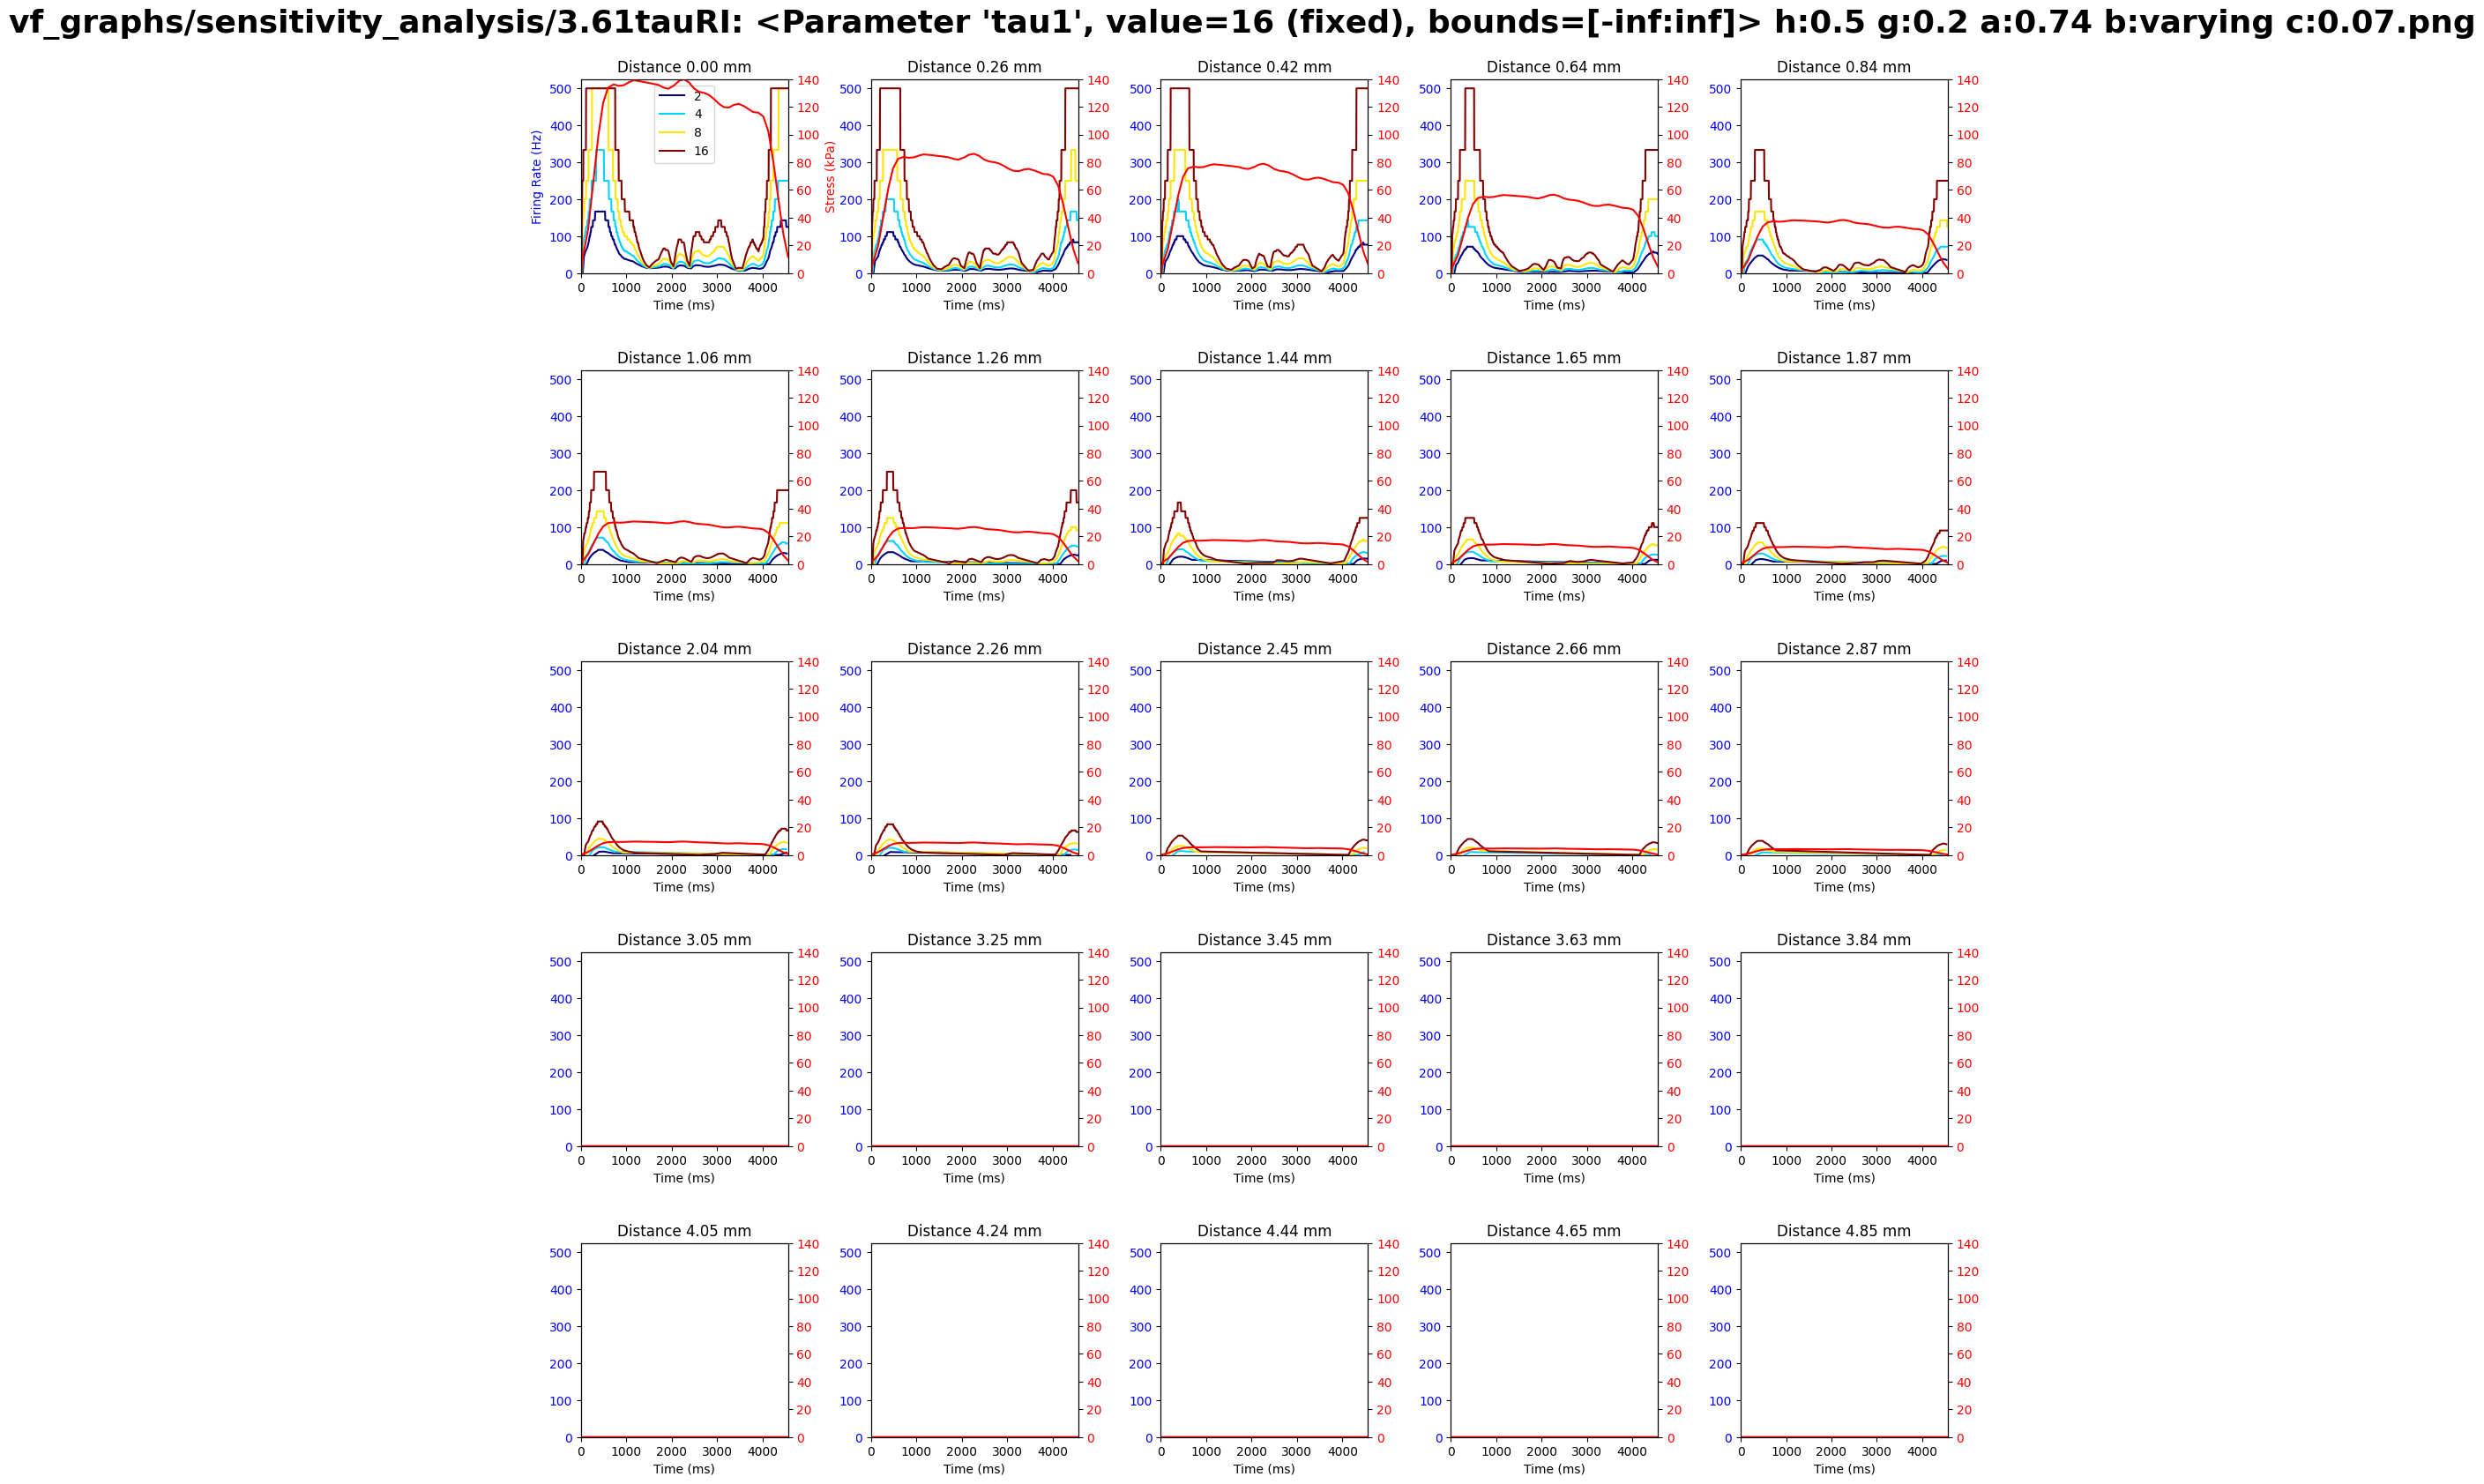

In [51]:
vf_model = VF_Population_Model(3.61, "SA", scaling_factor= 1.0)
vf_model.radial_stress_vf_model(.2,.5)
vf_model.sensitivity_analysis("b")

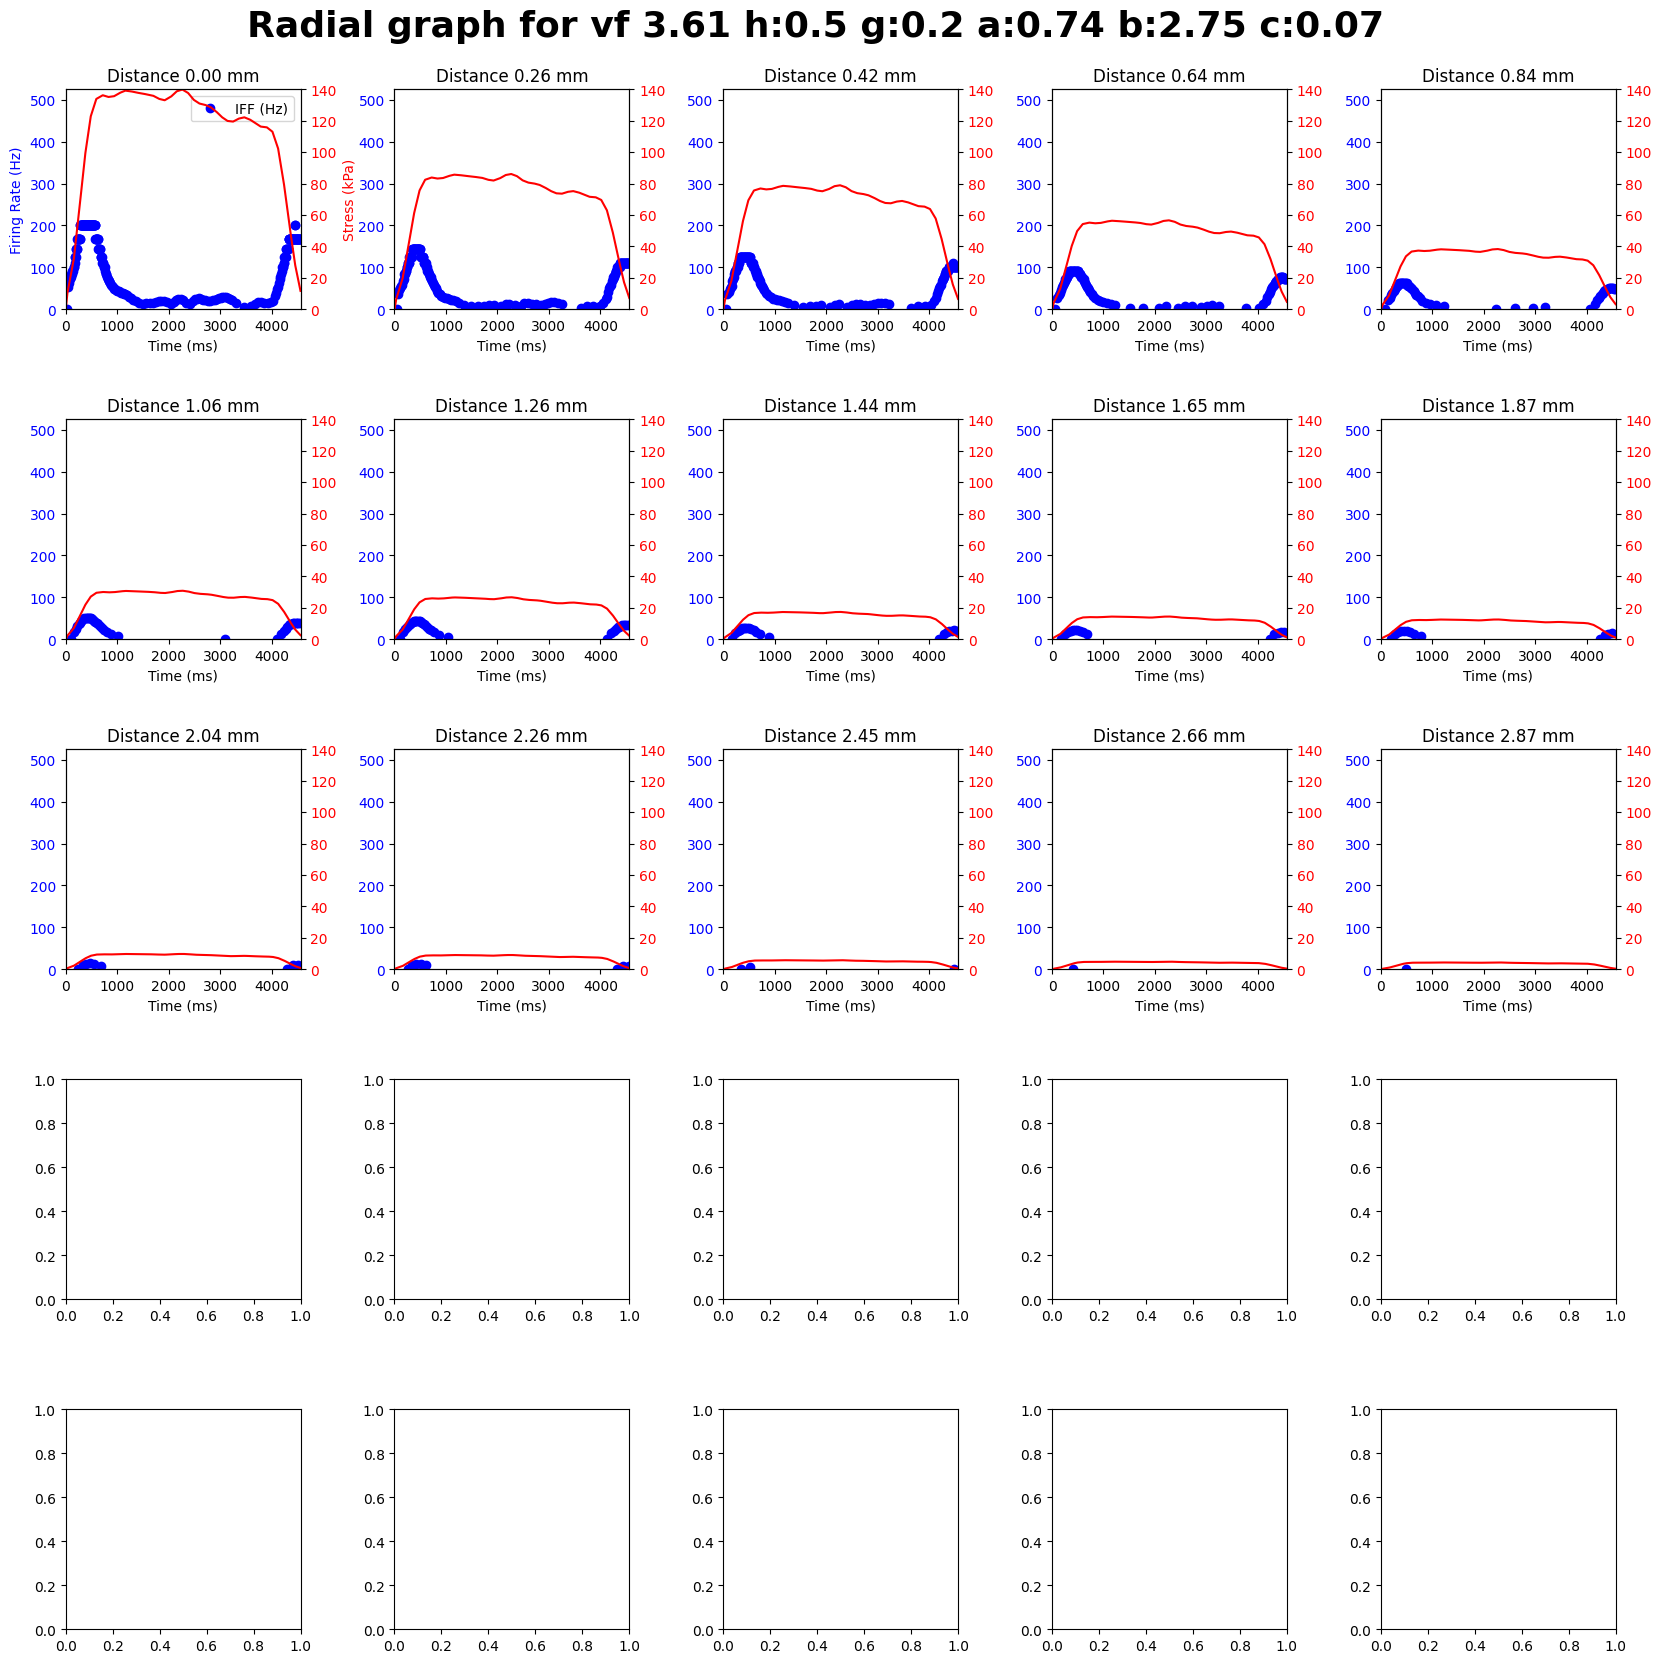

In [30]:
vf_model = VF_Population_Model(3.61, "SA", scaling_factor= 1.0)
vf_model.radial_stress_vf_model(.2,.5)
vf_model.run_single_unit_model_combined_graph()


#### Generating the Spatial Plots

x: 9.37579 y: 4.32477 peak_iff: 0.5
x: 6.16837 y: 3.42743 peak_iff: 0.14285714285714285
x: 9.08444 y: 2.74532 peak_iff: 0.16666666666666666
x: 10.8809 y: 2.65255 peak_iff: 0.024390243902439025
x: 5.45335 y: 3.73725 peak_iff: 0.08333333333333333
x: 9.37579 y: 4.32477 peak_iff: 0.5
x: 10.6228 y: 4.49663 peak_iff: 0.25
x: 12.6121 y: 4.38191 peak_iff: 0.01818181818181818
x: 7.11013 y: 6.33472 peak_iff: 0.1111111111111111
x: 9.1414 y: 6.17783 peak_iff: 0.25
x: 10.6651 y: 6.34813 peak_iff: 0.047619047619047616


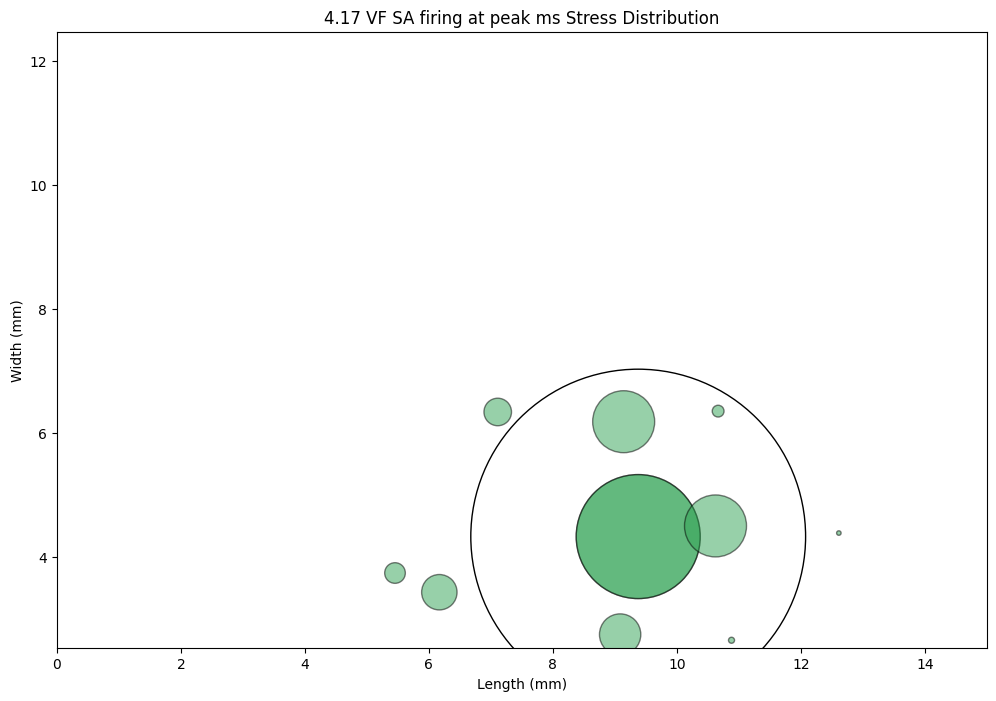

In [5]:
vf_model.spatial_stress_vf_model()
vf_model.plot_spatial_coords()

**Configuring the Von-Frey Population Model**

In [6]:
iffs = vf_model.get_iffs()

for iff in iffs:
    print(iff)

AttributeError: 'VF_Population_Model' object has no attribute 'get_iffs'

**Randomly Generating Afferents and setting up the configuration for the Simulation**

In [ ]:
tongue_size = (10,18)  # in mm
density_ratio = (1, 0)  # Ratio of SA and RA afferents
n_afferents = 1500
rf_sizes = {
    'SA': [1],
    'RA': [1]
}

config = SimulationConfig(tongue_size, density_ratio, n_afferents, rf_sizes,
                          stimulus_diameter=None, 
                          x_stimulus=None, y_stimulus=None,
                          stress=None)

simulation = Simulation(config)

afferents = simulation.get_afferents()


**Getting Stress & Firing Data for the Afferents**

In [ ]:
stress_data = []
iff_data = []

stresses, iffs = vf_model.simulate_afferent_response(afferents)

**Creating The Plot**

In [ ]:
vf_model.plot_afferents(iffs, afferents)

In [ ]:
stress_results.get(4).get(0.0), 
iffs_results.get(4).get(0.0)

In [ ]:
iffs_results.get(3)